### use this notebook in jlab env from timeseries course

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
import seaborn as sns
from scipy import stats    #Used for 2D binned statistics
import xarray as xr
import analytic_wavelet
from scipy import signal, ndimage
from datetime import timedelta
analytic_wavelet.__file__

'/home/jonathan/miniconda3/envs/jlab/lib/python3.12/site-packages/analytic_wavelet/__init__.py'

In [2]:
#import data
rcm474_path = "./dataset/rcm474"
rcm506_path = "./dataset/rcm506"
rcm512_path = "./dataset/rcm512"
rcm569_path = "./dataset/rcm569"

rcm474_joel_path = "./dataset/RCM_1"

rcm474 = pd.read_csv(rcm474_path,names=['datetime','u','v'])
rcm506 = pd.read_csv(rcm506_path,names=['datetime','u','v'])
rcm512 = pd.read_csv(rcm512_path,names=['datetime','u','v'])
rcm569 = pd.read_csv(rcm569_path,names=['datetime','u','v'])

time_vec = pd.date_range(pd.to_datetime(rcm569.datetime.iloc[0]),pd.to_datetime(rcm569.datetime.iloc[-1]),freq='h')
rcm569.datetime = time_vec


#22.07.2022 10:27:00 - 06.07.2023 06:57:00
sdate = pd.to_datetime('22.07.2022 10:27:00')
edate = pd.to_datetime('06.07.2023 06:57:00')

rcm474_joel = pd.read_csv(rcm474_joel_path,header=None)
rcm474_joel['u'] = rcm474_joel[0]
rcm474_joel['v'] = rcm474_joel[1]
rcm474_joel['cv'] = rcm474_joel.u + 1j*rcm474_joel.v
rcm474_joel['datetime'] =  pd.date_range(sdate,edate,periods=len(rcm474_joel.u))
rcm474_joel.drop(rcm474_joel.tail(80).index,inplace=True) #remove deployment and recovery
rcm474_joel.drop(rcm474_joel.head(80).index,inplace=True)


for i in rcm474,rcm506,rcm512,rcm569:
    i.datetime = pd.to_datetime(i.datetime,yearfirst=True)
    i['cv'] = i.u + 1j*i.v

dt = 1/24 #sampling interval in days
rcm474
#rcm474 = rcm474_joel

/tmp/ipykernel_87068/1922666641.py:19: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sdate = pd.to_datetime('22.07.2022 10:27:00')


,datetime,u,v,cv
0,2022-07-25 14:59:00,1.341400,2.30930,1.341400+2.309300j
1,2022-07-25 15:59:00,-3.438300,7.30030,-3.438300+7.300300j
2,2022-07-25 16:59:00,0.078316,-0.27305,0.078316-0.273050j
3,2022-07-25 17:59:00,-0.227640,0.18278,-0.227640+0.182780j
4,2022-07-25 18:59:00,-1.529800,-1.33720,-1.529800-1.337200j
...,...,...,...,...
8211,2023-07-02 17:57:00,-1.719600,-1.45980,-1.719600-1.459800j
8212,2023-07-02 18:57:00,0.035302,-0.93775,0.035302-0.937750j
8213,2023-07-02 19:57:00,0.083848,-2.02040,0.083848-2.020400j
8214,2023-07-02 20:57:00,-0.202010,-1.46580,-0.202010-1.465800j


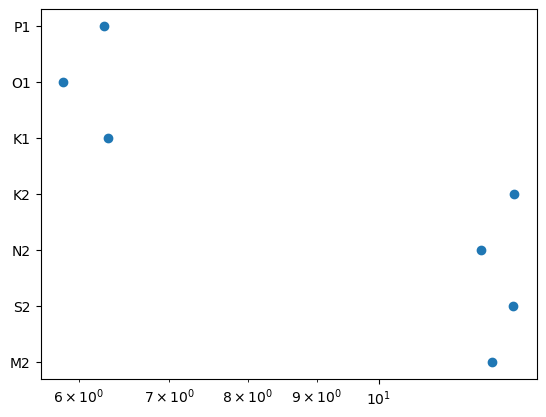

In [5]:
from multitaper import MTSpec  #using German Prieto's multitaper package, https://github.com/gaprieto/multitaper
from scipy.special import digamma
from scipy.stats import chi2

lat=82

#define functions to return the Coriolis and tidal frequqncies
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Args: 
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    f = 2*np.sin(lat*2*np.pi/360)*omega*(3600)*24
    two_f = 2*f
    three_f = 3*f
    return np.array([f,two_f,three_f]);

def tidefreq():
    """
    Eight major tidal frequencies in rad / day.  See Gill (1982) page 335.
    
    Args: 
        None
        
    Returns:
        An array of eight frequencies
        periods in h
        #from Gill 1982
        M2=12.42  , S2=12 , N2=12.66 , K2=11.97 , K1=23.93, O1=25.82, P1=24.07
        #from Wiki
        M2=12.4206012  , S2=12 , N2=12.65834751 , K2=11.96723606 , 2N2=12.90537297 , K1=23.93447213 , O1=25.81933871 , P1=24.06588766 , Q1=26.868350 , M4=6.210300601 , MS4=6.103339275 , MN4=6.269173724
    """    
    #return 24*2*np.pi/np.array([12.4206012,12,12.65834751,11.96723606,12.90537297,23.93447213,25.81933871,24.06588766,26.868350,6.210300601,6.103339275,6.269173724])
    return 24*2*np.pi/np.array([12.42,12,12.66,11.97,23.93,25.82,24.07])

#plt.scatter(tidefreq(),['M2','S2','N2','K2','2N2','K1','O1','P1','Q1','M4','MS4','MN4'])
plt.scatter(tidefreq(),['M2','S2','N2','K2','K1','O1','P1'])
plt.gca().set_xscale('log')

/home/jonathan/miniconda3/envs/jlab/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


8.081881339012392
4.273757235535445
4.018343801179429
5.019089357601742


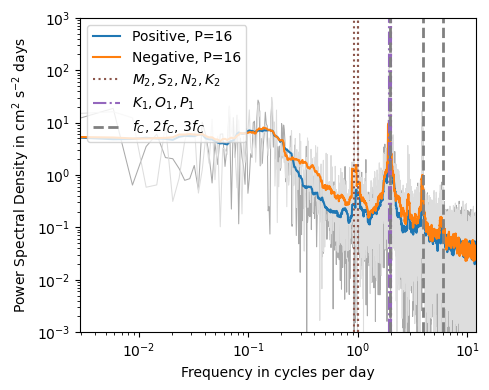

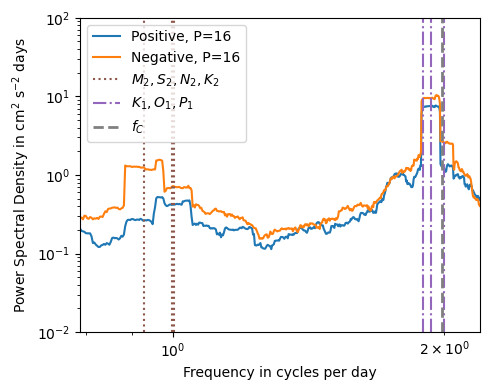

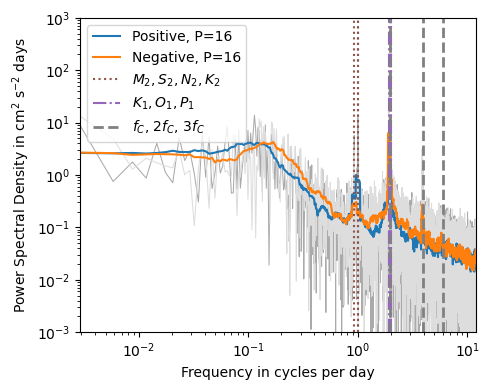

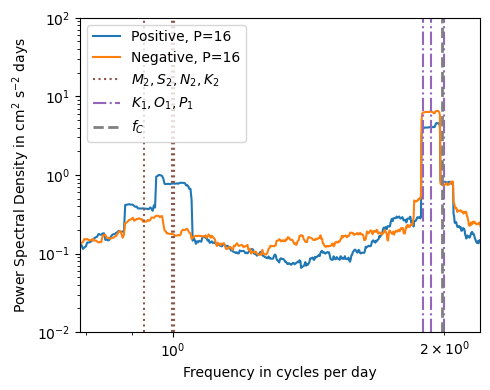

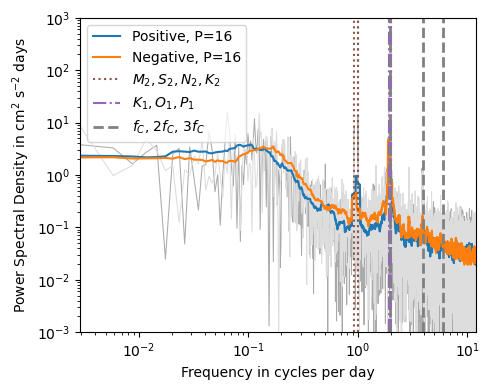

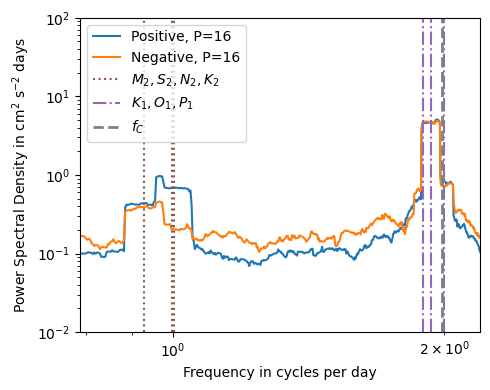

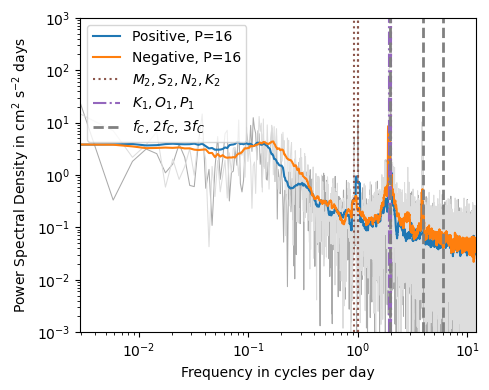

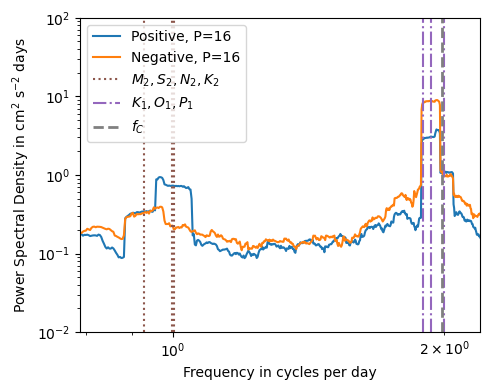

In [7]:
#spectrogram for master thesis
rcm_dict = {'rcm474':rcm474,'rcm506':rcm506,'rcm512':rcm512,'rcm569':rcm569}


for key in rcm_dict:
    cv = np.array(rcm_dict[key].cv)
    
    fo, So = sg.periodogram(cv-np.mean(cv), fs=1/dt) #fs = sampling frequency (cyclic)
    
    P = 16
    spec = MTSpec(cv-np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
    S = np.ravel(spec.spec)
    f = np.ravel(spec.freq)
    
    print((f[1]-f[0])*np.sum(S)) #verify variance is approximately recovered
    #np.std(cv)**2
    
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    #plot unfiltered
    ax.loglog( fo[np.where(fo>0)],So[np.where(fo>0)],linewidth=0.75,color="#AAAAAA")#plot positive side
    ax.loglog(-fo[np.where(fo<0)],So[np.where(fo<0)],linewidth=0.75,color="#DDDDDD")#plot negative side
    #plot filtered
    h1,=ax.loglog( f[np.where(f>0)],S[np.where(f>0)],label='Positive, P=16')#plot positive side
    h2,=ax.loglog(-f[np.where(f<0)],S[np.where(f<0)],label='Negative, P=16')#plot negative side
    ax.autoscale(enable=True, tight=True)
    ax.set_ylim(1e-3, 1e3)

    tides2 = ax.vlines(tidefreq()[3:]/2/np.pi,ax.get_ylim()[0],ax.get_ylim()[1],linestyle=":",color='tab:brown',label='$M_2,S_2,N_2,K_2$')
    tides1 = ax.vlines(tidefreq()[:2]/2/np.pi,ax.get_ylim()[0],ax.get_ylim()[1],linestyle="dashdot",color='tab:purple',label='$K_1,O_1,P_1$')
    ax.vlines(corfreq(lat)/2/np.pi,ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--", color="gray",linewidth=2,label='$f_C$, $2f_C$, $3f_C$')
    
    ax.legend(loc='upper left')
    plt.xlabel('Frequency in cycles per day')
    plt.ylabel('Power Spectral Density in cm$^2$ s$^{-2}$ days')
    fig.tight_layout()
    plt.savefig('/home/jonathan/Dokumente/Masterarbeit/Thesis_Latex_Project/figures/4-results/4-2-time/'+str(key)+'_spectroP16.png',dpi=300)


    fig, ax = plt.subplots(1, 1,figsize=(5,4))
    ax.loglog( f[np.where(f>0)],S[np.where(f>0)],label='Positive, P=16')#plot positive side
    ax.loglog(-f[np.where(f<0)],S[np.where(f<0)],label='Negative, P=16')#plot negative side
    ax.autoscale(enable=True, tight=True)
    ax.set_xlim(f[270], f[750])   # <------------------------------ Tighten x-axis
    ax.set_ylim(1e-2, 1e2)

    tides2 = ax.vlines(tidefreq()[4:]/2/np.pi,ax.get_ylim()[0],ax.get_ylim()[1],linestyle=":",color='tab:brown',label='$M_2,S_2,N_2,K_2$')
    tides1 = ax.vlines(tidefreq()[:3]/2/np.pi,ax.get_ylim()[0],ax.get_ylim()[1],linestyle="dashdot",color='tab:purple',label='$K_1,O_1,P_1$')
    ax.vlines(corfreq(lat)/2/np.pi,ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--", color="gray",linewidth=2,label='$f_C$')
    
    ax.legend(loc='upper left')
    plt.xlabel('Frequency in cycles per day')
    plt.ylabel('Power Spectral Density in cm$^2$ s$^{-2}$ days')
    fig.tight_layout()
    plt.savefig('/home/jonathan/Dokumente/Masterarbeit/Thesis_Latex_Project/figures/4-results/4-2-time/'+str(key)+'_spectroP16_zoom.png',dpi=300)